<a href="https://colab.research.google.com/github/kmcguigan1/MNIST-Convs-Torch/blob/submission/MNIST_Model_Optuna_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import statements
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# use Cuda: change runtime environment to T4 GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
# initialize parameters

# mean and standard deviation corresponding to the MNIST dataset
mnist_mean = 0.1307
mnist_std_dev = 0.3081

# train and test batch sizes
train_batch_size = 512
test_batch_size = 1000

# learning rate
lr = 0.0021
# number of epochs
epochs = 20

In [4]:
def plot_mnist(data):
    """
    Function that plots the MNIST images

    Parameters
    ----------
    data: the image to be plotted
    """
    # plot a subset of MNIST examples
    fig, axs = plt.subplots(4, 5, figsize=(5, 6))

    plot_images = []
    plot_labels = []

    for i, ax in enumerate(axs.flatten(), start=1000):
        (image, label) = data[i]

        # save the data
        plot_images.append(image)
        plot_labels.append(label)

        # plot each image
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 35159104.38it/s]


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97141695.13it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37696382.36it/s]


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3435622.86it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



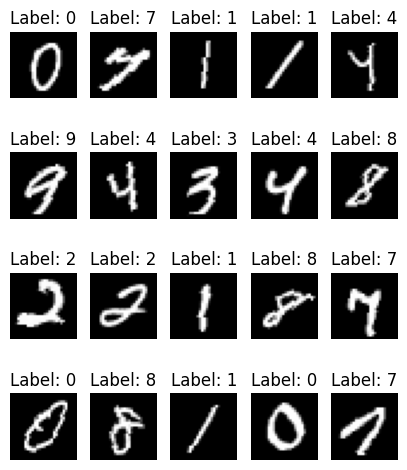

In [5]:
# train and test image transforms
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=12),
    torchvision.transforms.GaussianBlur(3, sigma=0.0420)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# train and test data
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=test_transform)

# train and test data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size)

# plot examples of training data
plot_mnist(train_data)

In [6]:
class CNN(nn.Module):
    """
    Pytorch CNN Model
    """
    def __init__(self):
        super().__init__()
        # convolution
        self.input_conv = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.input_norm = nn.BatchNorm2d(32)
        self.input_relu = nn.ReLU()
        self.input_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.hidden_conv = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.hidden_norm = nn.BatchNorm2d(64)
        self.hidden_relu = nn.ReLU()
        self.hidden_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.output_conv = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.output_norm = nn.BatchNorm2d(128)
        self.output_relu = nn.ReLU()
        self.output_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # classification
        self.dropout1 = nn.Dropout(0.0815)
        self.input_dense = nn.Linear(128,64)
        self.input_dense_norm = nn.BatchNorm1d(64)
        self.input_dense_relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.0815)
        self.output_dense = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        """
        Function corresponding to the forward pass of the network

        Parameters
        ----------
            x : the input Tensor
        Returns
        ----------
            x: the output Tensor
        """
        x = self.input_conv(x)
        x = self.input_norm(x)
        x = self.input_relu(x)
        x = self.input_pool(x)

        x = self.hidden_conv(x)
        x = self.hidden_norm(x)
        x = self.hidden_relu(x)
        x = self.hidden_pool(x)

        x = self.output_conv(x)
        x = self.output_norm(x)
        x = self.output_relu(x)
        x = self.output_pool(x)

        x = self.dropout1(x)

        x = x.squeeze()

        x = self.input_dense(x)
        x = self.input_dense_norm(x)
        x = self.input_dense_relu(x)
        x = self.dropout2(x)

        x = self.output_dense(x)
        x = self.softmax(x)

        return x

In [7]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Function used in training the Pytorch model for one epoch

    Parameters
    ----------
    model: the Pytorch model
    train_loader: the Pytorch data loader for the training data
    loss_fn: the Pytorch loss function
    optimizer: the Pytorch optimizer
    epoch: the current epoch

    Returns
    ----------
    acc: the accuracy score
    final_loss: the final loss
    """
    # initialize parameters
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE) # included so we can use Cuda
    model.train()  # set the model in training mode

    for i, (inputs, targets) in enumerate(train_loader): # fetch the next batch of data
        optimizer.zero_grad() # zero the parameter gradients
        inputs = inputs.to(DEVICE) # for use of Cuda
        outputs = model(inputs) # compute the model outputs
        loss = loss_fn(outputs, targets.to(DEVICE)) # compute the loss between model outputs and targets (using Cuda)
        loss.backward() # backpropagation
        optimizer.step() # gradient descent


        # Track some values to compute statistics
        total_loss += loss.item()
        # compute the model predictions
        preds = torch.argmax(outputs, dim=-1) # class with the highest output is the prediction

        # track predictions and targets (using Cuda)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # save the loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)

    # compute the accuracy score and final loss
    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)

    # print the average loss and accuracy
    print(f"Epoch {epoch + 1}: average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [8]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Function used in testing the Pytorch model for one epoch

    Parameters
    ----------
    model: the Pytorch model
    test_loader: the Pytorch data loader for the test data
    loss_fn: the Pytorch loss function
    epoch: the current epoch

    Returns
    ----------
    acc: the accuracy score
    final_loss: the final loss
    """
    # initialize parameters
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE) # included so we can use Cuda
    model.eval()  # set the model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader): # fetch next batch of data
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE)) # compute the model predictions (using Cuda)
            loss = loss_fn(outputs, targets.to(DEVICE)) # compute the loss between model outputs and targets (using Cuda)

            # tracking for statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1) # class with the highest output is the prediction

            # track predictions and targets (using Cuda)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    # compute the accuracy score and final loss
    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # print the average loss and accuracy
    print(f"Epoch {epoch + 1}: average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [9]:
# initialize the model
torch.manual_seed(0)
model = CNN()
optimizer = optim.Adam(model.parameters(), lr, weight_decay = 3.9109e-6)
loss_fn = nn.CrossEntropyLoss()

In [10]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []

# train and test the model
for epoch in range(epochs):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

Epoch 1: average train loss = 1.72, average train accuracy = 81.130%
Epoch 1: average test loss = 1.60, average test accuracy = 88.340%
Epoch 2: average train loss = 1.50, average train accuracy = 97.117%
Epoch 2: average test loss = 1.61, average test accuracy = 87.210%
Epoch 3: average train loss = 1.49, average train accuracy = 97.865%
Epoch 3: average test loss = 1.48, average test accuracy = 98.280%
Epoch 4: average train loss = 1.48, average train accuracy = 98.162%
Epoch 4: average test loss = 1.50, average test accuracy = 97.020%
Epoch 5: average train loss = 1.48, average train accuracy = 98.398%
Epoch 5: average test loss = 1.48, average test accuracy = 98.330%
Epoch 6: average train loss = 1.48, average train accuracy = 98.560%
Epoch 6: average test loss = 1.48, average test accuracy = 98.320%
Epoch 7: average train loss = 1.48, average train accuracy = 98.675%
Epoch 7: average test loss = 1.47, average test accuracy = 99.090%
Epoch 8: average train loss = 1.48, average trai

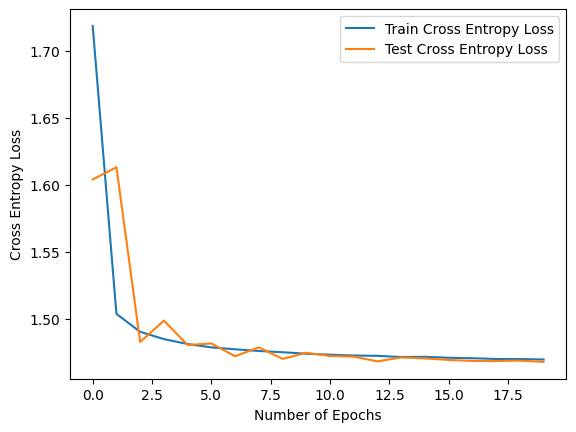

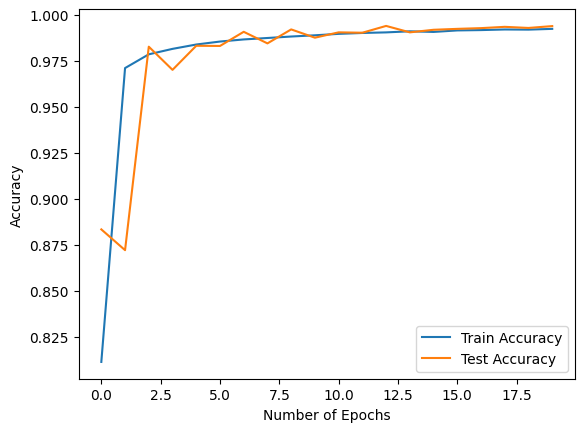

In [11]:
def plot_stats(train, test, title):
    """
    Function that plots the model's accuracy or loss

    Parameters
    ----------
    train: the metric corresponding to the train data
    test: the metric corresponding to the test data
    title: the title of the plot
    """

    plt.plot(train, label='Train ' + title)
    plt.plot(test, label='Test ' + title)
    plt.xlabel("Number of Epochs")
    plt.ylabel(title)
    plt.legend()
    plt.show()

plot_stats(train_losses, test_losses, "Cross Entropy Loss")
plot_stats(train_metrics, test_metrics, "Accuracy")